In [1]:
%%capture
!pip install optuna

In [2]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import random
import numpy as np
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

import shutil
shutil.copy("/content/drive/MyDrive/Colab Notebooks/METABRIC/METABRIC_utils.py", "/content/")
import METABRIC_utils as utils
# from METABRIC_utils import *

In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/METABRIC/METABRIC_RNA_Mutation.csv'

# Read the CSV file from Google Drive
df = pd.read_csv(file_path)

<ipython-input-3-e2bacf3cedbb>:4: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [4]:
z_scores = df.columns[31:519].tolist()

# FEATURE_COLS = df.columns[31:519]
FEATURE_COLS = z_scores #+ ['mutation_count']
TARGET_COL = 'overall_survival_months'

# Descriptive features

Clinical criteria, mutations, and Z-score for expression levels.  
Mutations are 0 if not mutated, and then a str value is given for the specific mutation if present. (*i.e there are multiple values for a mutation column which would probably need to be one-hot encoded*).  
<br>
Z-scores are listed under the name of the gene. They are numerical values.  
<br>
Might just start trying with only Z-scores, as is simpler and will implicitly contain *some* information about the mutation. Then see if its better if we include mutation as well (one hot encoded).

In [5]:
pd.set_option('display.max_rows', None)

# df.dtypes

In [6]:
pd.set_option('display.max_columns', None)

df.describe() #think only shows numerical values

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,e2f7,e2f8,src,jak1,jak2,stat1,stat2,stat3,stat5a,stat5b,mdm2,tp53bp1,adam10,adam17,aph1a,aph1b,arrdc1,cir1,ctbp1,ctbp2,cul1,dll1,dll3,dll4,dtx1,dtx2,dtx3,dtx4,ep300,fbxw7,hdac1,hdac2,hes1,hes5,heyl,itch,jag1,jag2,kdm5a,lfng,maml1,maml2,maml3,ncor2,ncstn,notch1,notch2,notch3,nrarp,numb,numbl,psen1,psen2,psenen,rbpj,rbpjl,rfng,snw1,spen,hes2,hes4,hes7,hey1,hey2,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,bad,bcl2,bcl2l1,bmp10,bmp15,bmp2,bmp3,bmp4,bmp5,bmp6,bmp7,bmpr1a,bmpr1b,bmpr2,braf,casp10,casp3,casp6,casp7,casp8,casp9,chek1,csf1,csf1r,cxcl8,cxcr1,cxcr2,dab2,diras3,dlec1,dph1,egfr,eif4e,eif4ebp1,eif5a2,erbb2,erbb3,erbb4,fas,fgf1,fgfr1,folr1,folr2,folr3,foxo1,foxo3,gdf11,gdf2,gsk3b,hif1a,hla-g,hras,igf1,igf1r,inha,inhba,inhbc,itgav,itgb3,izumo1r,kdr,kit,kras,map2k1,map2k2,map2k3,map2k4,map2k5,map3k1,map3k3,map3k4,map3k5,mapk1,mapk12,mapk14,mapk3,mapk4,mapk6,mapk7,mapk8,mapk9,mdc1,mlst8,mmp1,mmp10,mmp11,mmp12,mmp13,mmp14,mmp15,mmp16,mmp17,mmp19,mmp2,mmp21,mmp23b,mmp24,mmp25,mmp26,mmp27,mmp28,mmp3,mmp7,mmp9,mtor,nfkb1,nfkb2,opcml,pdgfa,pdgfb,pdgfra,pdgfrb,pdpk1,peg3,pik3ca,pik3r1,pik3r2,plagl1,ptk2,rab25,rad51,raf1,rassf1,rheb,rictor,rps6,rps6ka1,rps6ka2,rps6kb1,rps6kb2,rptor,slc19a1,smad1,smad2,smad3,smad4,smad5,smad6,smad7,smad9,sptbn1,terc,tert,tgfb1,tgfb2,tgfb3,tgfbr1,tgfbr2,tgfbr3,tsc1,tsc2,vegfa,vegfb,wfdc2,wwox,zfyve9,arid1a,arid1b,cbfb,gata3,kmt2c,kmt2d,myh9,ncor1,pde4dip,ptprd,ros1,runx1,tbx3,abcb1,abcb11,abcc1,abcc10,bbc3,bmf,cyp2c8,cyp3a4,fgf2,fn1,map2,map4,mapt,nr1i2,slco1b3,tubb1,tubb4a,tubb4b,twist1,adgra2,afdn,aff2,agmo,agtr2,ahnak,ahnak2,akap9,alk,apc,arid2,arid5b,asxl1,asxl2,bap1,bcas3,birc6,cacna2d3,ccnd3,chd1,clk3,clrn2,col12a1,col22a1,col6a3,ctcf,ctnna1,ctnna3,dnah11,dnah2,dnah5,dtwd2,fam20c,fanca,fancd2,flt3,foxp1,frmd3,gh1,gldc,gpr32,gps2,hdac9,herc2,hist1h2bc,kdm3a,kdm6a,klrg1,l1cam,lama2,lamb3,large1,ldlrap1,lifr,lipi,magea8,map3k10,map3k13,men1,mtap,muc16,myo1a,myo3a,ncoa3,nek1,nf2,npnt,nr2f1,nr3c1,nras,nrg3,nt5e,or6a2,palld,pbrm1,ppp2cb,ppp2r2a,prkacg,prkce,prkcq,prkcz,prkg1,prps2,prr16,ptpn22,ptprm,rasgef1b,rpgr,ryr2,sbno1,setd1a,setd2,setdb1,sf3b1,sgcd,shank2,siah1,sik1,sik2,smarcb1,smarcc1,smarcc2,smarcd1,spaca1,stab2,stmn2,syne1,taf1,taf4b,tbl1xr1,tg,thada,thsd7a,ttyh1,ubr5,ush2a,usp9x,utrn,zfp36l1,ackr3,akr1c1,akr1c2,akr1c3,akr1c4,akt3,ar,bche,cdk8,cdkn2c,cyb5a,cyp11a1,cyp11b2,cyp17a1,cyp19a1,cyp21a2,cyp3a43,cyp3a5,cyp3a7,ddc,hes6,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1904.000000,1904.000000,1904.000000,1904.000000,1832.000000,1904.000000,1904.000000,1859.000000,1904.000000,1904.000000,1904.000000,1904.000000,1884.000000,1403.000000,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1.9

Do the input features need standardising?
<br>
Yes



In [7]:
def scale_features(df, features, min=-1, max=1):
  """
  Scales the features in a DataFrame.
  Args:
    df (pandas.DataFrame): The input DataFrame.
    features (list): A list of feature
    min: minimum value in scale (default = -1)
    max: maximum value in scale (default = 1)
  Returns:
    scaled_df (pandas.DataFrame): The DataFrame with scaled features.
  """
  scaler = MinMaxScaler(feature_range=(min, max))
  scaled_df = df[:]
  scaled_df[features] = scaler.fit_transform(df[features])

  return scaled_df

scaled_df = scale_features(df, FEATURE_COLS)
scaled_df.describe()

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,e2f7,e2f8,src,jak1,jak2,stat1,stat2,stat3,stat5a,stat5b,mdm2,tp53bp1,adam10,adam17,aph1a,aph1b,arrdc1,cir1,ctbp1,ctbp2,cul1,dll1,dll3,dll4,dtx1,dtx2,dtx3,dtx4,ep300,fbxw7,hdac1,hdac2,hes1,hes5,heyl,itch,jag1,jag2,kdm5a,lfng,maml1,maml2,maml3,ncor2,ncstn,notch1,notch2,notch3,nrarp,numb,numbl,psen1,psen2,psenen,rbpj,rbpjl,rfng,snw1,spen,hes2,hes4,hes7,hey1,hey2,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,bad,bcl2,bcl2l1,bmp10,bmp15,bmp2,bmp3,bmp4,bmp5,bmp6,bmp7,bmpr1a,bmpr1b,bmpr2,braf,casp10,casp3,casp6,casp7,casp8,casp9,chek1,csf1,csf1r,cxcl8,cxcr1,cxcr2,dab2,diras3,dlec1,dph1,egfr,eif4e,eif4ebp1,eif5a2,erbb2,erbb3,erbb4,fas,fgf1,fgfr1,folr1,folr2,folr3,foxo1,foxo3,gdf11,gdf2,gsk3b,hif1a,hla-g,hras,igf1,igf1r,inha,inhba,inhbc,itgav,itgb3,izumo1r,kdr,kit,kras,map2k1,map2k2,map2k3,map2k4,map2k5,map3k1,map3k3,map3k4,map3k5,mapk1,mapk12,mapk14,mapk3,mapk4,mapk6,mapk7,mapk8,mapk9,mdc1,mlst8,mmp1,mmp10,mmp11,mmp12,mmp13,mmp14,mmp15,mmp16,mmp17,mmp19,mmp2,mmp21,mmp23b,mmp24,mmp25,mmp26,mmp27,mmp28,mmp3,mmp7,mmp9,mtor,nfkb1,nfkb2,opcml,pdgfa,pdgfb,pdgfra,pdgfrb,pdpk1,peg3,pik3ca,pik3r1,pik3r2,plagl1,ptk2,rab25,rad51,raf1,rassf1,rheb,rictor,rps6,rps6ka1,rps6ka2,rps6kb1,rps6kb2,rptor,slc19a1,smad1,smad2,smad3,smad4,smad5,smad6,smad7,smad9,sptbn1,terc,tert,tgfb1,tgfb2,tgfb3,tgfbr1,tgfbr2,tgfbr3,tsc1,tsc2,vegfa,vegfb,wfdc2,wwox,zfyve9,arid1a,arid1b,cbfb,gata3,kmt2c,kmt2d,myh9,ncor1,pde4dip,ptprd,ros1,runx1,tbx3,abcb1,abcb11,abcc1,abcc10,bbc3,bmf,cyp2c8,cyp3a4,fgf2,fn1,map2,map4,mapt,nr1i2,slco1b3,tubb1,tubb4a,tubb4b,twist1,adgra2,afdn,aff2,agmo,agtr2,ahnak,ahnak2,akap9,alk,apc,arid2,arid5b,asxl1,asxl2,bap1,bcas3,birc6,cacna2d3,ccnd3,chd1,clk3,clrn2,col12a1,col22a1,col6a3,ctcf,ctnna1,ctnna3,dnah11,dnah2,dnah5,dtwd2,fam20c,fanca,fancd2,flt3,foxp1,frmd3,gh1,gldc,gpr32,gps2,hdac9,herc2,hist1h2bc,kdm3a,kdm6a,klrg1,l1cam,lama2,lamb3,large1,ldlrap1,lifr,lipi,magea8,map3k10,map3k13,men1,mtap,muc16,myo1a,myo3a,ncoa3,nek1,nf2,npnt,nr2f1,nr3c1,nras,nrg3,nt5e,or6a2,palld,pbrm1,ppp2cb,ppp2r2a,prkacg,prkce,prkcq,prkcz,prkg1,prps2,prr16,ptpn22,ptprm,rasgef1b,rpgr,ryr2,sbno1,setd1a,setd2,setdb1,sf3b1,sgcd,shank2,siah1,sik1,sik2,smarcb1,smarcc1,smarcc2,smarcd1,spaca1,stab2,stmn2,syne1,taf1,taf4b,tbl1xr1,tg,thada,thsd7a,ttyh1,ubr5,ush2a,usp9x,utrn,zfp36l1,ackr3,akr1c1,akr1c2,akr1c3,akr1c4,akt3,ar,bche,cdk8,cdkn2c,cyb5a,cyp11a1,cyp11b2,cyp17a1,cyp19a1,cyp21a2,cyp3a43,cyp3a5,cyp3a7,ddc,hes6,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1904.000000,1904.000000,1904.000000,1904.000000,1832.000000,1904.000000,1904.000000,1859.000000,1904.000000,1904.000000,1904.000000,1904.000000,1884.000000,1403.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.0

# Data pre-processing

Removing people who are alive, as they may be early in the treatmnet journey and could bias towards low survival times.  
Then filter out everything except z-scores.  
When test/train/val split want to stratify by length of survival time.  
<br>
May also want to consider stratifying by type of cancer.  
<br>  
I found that the neural networks were slightly better when the gene expression data wasstandardised to a range of -1 : 1.

In [8]:
print(len(df))

1904


In [9]:
# standardise features with a range of [-1,1]
def scale_features(df, features, min=-1, max=1):
  """
  Scales the features in a DataFrame.
  Args:
    df (pandas.DataFrame): The input DataFrame.
    features (list): A list of feature
    min: minimum value in scale (default = -1)
    max: maximum value in scale (default = 1)
  Returns:
    scaled_df (pandas.DataFrame): The DataFrame with scaled features.
  """
  scaler = MinMaxScaler(feature_range=(min, max))
  scaled_df = df[:]
  scaled_df[features] = scaler.fit_transform(df[features])

  return scaled_df

# Custom function to determine survival length category
def categorize_survival(months):
    if months < 43:
        return '1st Quartile'
    elif months >= 43 and months < 86:
        return '2nd Quartile'
    elif months >= 86 and months < 145:
        return '3rd Quartile'
    else:
        return '4th Quartile'

def filter_df(df):
  df = df[df['overall_survival'] == 0] # remove people still alive
  z_score_cols = df.columns[31:519] # cols with z-scores
  filter_columns = ['patient_id','overall_survival_months'] + FEATURE_COLS

  df = df[filter_columns]
  df['survival_category'] = df['overall_survival_months'].apply(categorize_survival)

  return df

df_filt = filter_df(df)
df_filt = scale_features(df_filt, FEATURE_COLS)
df_filt.head()
print(f'Number of samples before filtering:{len(df)} \nNumber of samples after filtering: {len(df_filt)}')

Number of samples before filtering:1904 
Number of samples after filtering: 1103


In [10]:
df_filt.describe()

,patient_id,overall_survival_months,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,bard1,mlh1,msh2,msh6,pms2,epcam,rad51c,rad51d,rad50,rb1,rbl1,rbl2,ccna1,ccnb1,cdk1,ccne1,cdk2,cdc25a,ccnd1,cdk4,cdk6,ccnd2,cdkn2a,cdkn2b,myc,cdkn1a,cdkn1b,e2f1,e2f2,e2f3,e2f4,e2f5,e2f6,e2f7,e2f8,src,jak1,jak2,stat1,stat2,stat3,stat5a,stat5b,mdm2,tp53bp1,adam10,adam17,aph1a,aph1b,arrdc1,cir1,ctbp1,ctbp2,cul1,dll1,dll3,dll4,dtx1,dtx2,dtx3,dtx4,ep300,fbxw7,hdac1,hdac2,hes1,hes5,heyl,itch,jag1,jag2,kdm5a,lfng,maml1,maml2,maml3,ncor2,ncstn,notch1,notch2,notch3,nrarp,numb,numbl,psen1,psen2,psenen,rbpj,rbpjl,rfng,snw1,spen,hes2,hes4,hes7,hey1,hey2,acvr1,acvr1b,acvr1c,acvr2a,acvr2b,acvrl1,akt1,akt1s1,akt2,apaf1,arl11,atr,aurka,bad,bcl2,bcl2l1,bmp10,bmp15,bmp2,bmp3,bmp4,bmp5,bmp6,bmp7,bmpr1a,bmpr1b,bmpr2,braf,casp10,casp3,casp6,casp7,casp8,casp9,chek1,csf1,csf1r,cxcl8,cxcr1,cxcr2,dab2,diras3,dlec1,dph1,egfr,eif4e,eif4ebp1,eif5a2,erbb2,erbb3,erbb4,fas,fgf1,fgfr1,folr1,folr2,folr3,foxo1,foxo3,gdf11,gdf2,gsk3b,hif1a,hla-g,hras,igf1,igf1r,inha,inhba,inhbc,itgav,itgb3,izumo1r,kdr,kit,kras,map2k1,map2k2,map2k3,map2k4,map2k5,map3k1,map3k3,map3k4,map3k5,mapk1,mapk12,mapk14,mapk3,mapk4,mapk6,mapk7,mapk8,mapk9,mdc1,mlst8,mmp1,mmp10,mmp11,mmp12,mmp13,mmp14,mmp15,mmp16,mmp17,mmp19,mmp2,mmp21,mmp23b,mmp24,mmp25,mmp26,mmp27,mmp28,mmp3,mmp7,mmp9,mtor,nfkb1,nfkb2,opcml,pdgfa,pdgfb,pdgfra,pdgfrb,pdpk1,peg3,pik3ca,pik3r1,pik3r2,plagl1,ptk2,rab25,rad51,raf1,rassf1,rheb,rictor,rps6,rps6ka1,rps6ka2,rps6kb1,rps6kb2,rptor,slc19a1,smad1,smad2,smad3,smad4,smad5,smad6,smad7,smad9,sptbn1,terc,tert,tgfb1,tgfb2,tgfb3,tgfbr1,tgfbr2,tgfbr3,tsc1,tsc2,vegfa,vegfb,wfdc2,wwox,zfyve9,arid1a,arid1b,cbfb,gata3,kmt2c,kmt2d,myh9,ncor1,pde4dip,ptprd,ros1,runx1,tbx3,abcb1,abcb11,abcc1,abcc10,bbc3,bmf,cyp2c8,cyp3a4,fgf2,fn1,map2,map4,mapt,nr1i2,slco1b3,tubb1,tubb4a,tubb4b,twist1,adgra2,afdn,aff2,agmo,agtr2,ahnak,ahnak2,akap9,alk,apc,arid2,arid5b,asxl1,asxl2,bap1,bcas3,birc6,cacna2d3,ccnd3,chd1,clk3,clrn2,col12a1,col22a1,col6a3,ctcf,ctnna1,ctnna3,dnah11,dnah2,dnah5,dtwd2,fam20c,fanca,fancd2,flt3,foxp1,frmd3,gh1,gldc,gpr32,gps2,hdac9,herc2,hist1h2bc,kdm3a,kdm6a,klrg1,l1cam,lama2,lamb3,large1,ldlrap1,lifr,lipi,magea8,map3k10,map3k13,men1,mtap,muc16,myo1a,myo3a,ncoa3,nek1,nf2,npnt,nr2f1,nr3c1,nras,nrg3,nt5e,or6a2,palld,pbrm1,ppp2cb,ppp2r2a,prkacg,prkce,prkcq,prkcz,prkg1,prps2,prr16,ptpn22,ptprm,rasgef1b,rpgr,ryr2,sbno1,setd1a,setd2,setdb1,sf3b1,sgcd,shank2,siah1,sik1,sik2,smarcb1,smarcc1,smarcc2,smarcd1,spaca1,stab2,stmn2,syne1,taf1,taf4b,tbl1xr1,tg,thada,thsd7a,ttyh1,ubr5,ush2a,usp9x,utrn,zfp36l1,ackr3,akr1c1,akr1c2,akr1c3,akr1c4,akt3,ar,bche,cdk8,cdkn2c,cyb5a,cyp11a1,cyp11b2,cyp17a1,cyp19a1,cyp21a2,cyp3a43,cyp3a5,cyp3a7,ddc,hes6,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17
count,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,1103.000000,110

In [11]:
df_filt['survival_category'].value_counts() #data is well balanced across the survival time

,count
survival_category,
1st Quartile,280
4th Quartile,277
3rd Quartile,274
2nd Quartile,272


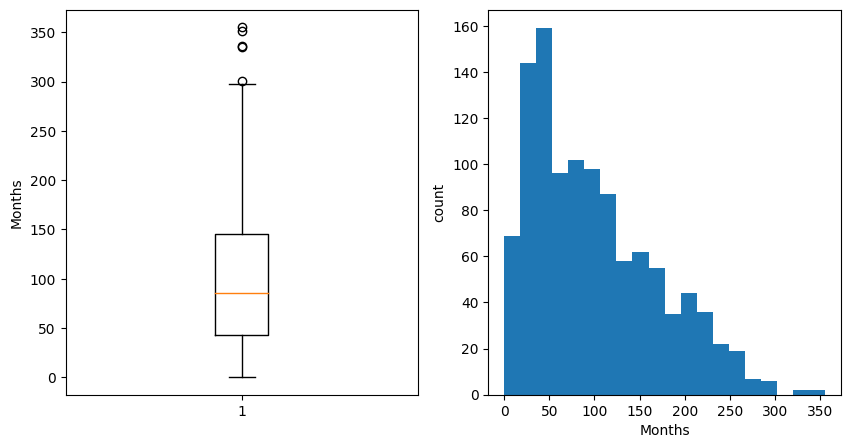

In [12]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].boxplot(df_filt['overall_survival_months'])
axes[0].set_ylabel('Months')

axes[1].hist(df_filt['overall_survival_months'], bins=20)
axes[1].set_ylabel('count')
axes[1].set_xlabel('Months')

plt.show()

In [13]:
def splitData(df, test_size, val_size):
  train_df, test_df = train_test_split(df,
                                       test_size=test_size,
                                       stratify=df['survival_category'],
                                       random_state=42
                                       )
  train_df, val_df = train_test_split(train_df,
                                       test_size=val_size,
                                       stratify=train_df['survival_category'],
                                       random_state=42
                                       )

  return train_df, test_df, val_df

train_df, test_df, val_df = splitData(df_filt, test_size = 0.1, val_size= 0.1)

print(f'Train size: {len(train_df)}')
print(f'Test size: {len(test_df)}')
print(f'Val size: {len(val_df)}')

Train size: 892
Test size: 111
Val size: 100


### Converting dataframe to tensor

In [14]:
def createTensors(df, features, target):
  """
  Converts a pandas dataframe into tensors
  Args:
    df (pandas.DataFrame): The input dataframe.
    features (list): A list of feature column names.
    target (str): The target column name.
  Returns:
    X (torch.Tensor): The feature tensor.
    y (torch.Tensor): The target tensor.
  """

  X = torch.tensor(df[features].values, dtype=torch.float32)
  y = torch.tensor(df[target].values,dtype=torch.float32)

  return X, y

def createTensorDataset(df, features, target):
  """
  Creates Tensor Dataset from a pandas dataframe.
  Args:
    df (pandas.DataFrame): The input dataframe.
    features (list): A list of feature column names.
    target (str): The target column name.
  Returns:
    Tensor dataset
  """
  X, y = createTensors(df, features, target)
  dataset = TensorDataset(X, y)

  return dataset

train_dataset = createTensorDataset(train_df, FEATURE_COLS, TARGET_COL)
test_dataset = createTensorDataset(test_df, FEATURE_COLS, TARGET_COL)
val_dataset = createTensorDataset(val_df, FEATURE_COLS, TARGET_COL)

In [15]:
train_X, train_y = createTensors(train_df, FEATURE_COLS, TARGET_COL)
print(f'Number of samples in training set: {len(train_df)}')
print(f'Number of features: {len(FEATURE_COLS)}')
print(f'Shape of tensor: {train_X.shape}')
# shape of tensor seems to be correct

Number of samples in training set: 892
Number of features: 488
Shape of tensor: torch.Size([892, 488])


# The model  

I think 12months as a Loss score is probably a good target to start aiming at. 6 months would be better.  
Want to create a flexible set of functions which will do the testing, then can run different experiments with different model hyperparameters.



In [16]:
# Set random seed for Python random module
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if using multiple GPUs

## Experiment 1: Full connected simple model
Start with a model consisting only of fully connected layers and dropout layers.  
Will tune these hyperparameters and then experiment with new layers etc.  
<br>
**Results**:  


*   The best scores were achieved by adding a 'contraction layer' which drastically reduces the number of units in the layer before expanding back out to an ordinary size fully connected layer.  
An 'unbalanced' structure, where the contraction layer is preceded by mutiple layers but followed by only a single layer, was more effective than a balanced approach.
*   This brought me down to a validation loss of ~50 MAE.  
*   These best hyperparameters are shown in the code below



## Constants

In [17]:
#### TRAINING CONSTANTS ####
BATCH_SIZE = 64
NUM_EPOCHS = 100 # Early stopping default is 3 epochs
LEARNING_RATE = 0.001
HIDDEN_SIZE = 128
CRITERION = nn.L1Loss() # MAE to avoid over penalising outliers


In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
train_dataloader.dataset.tensors[0].shape

torch.Size([892, 488])

In [20]:
# Create model class
class ModelFC(nn.Module): #inherits nn.Module class
  def __init__(self,
               input_dim, #input features
               hidden_dim, #features in hidden layers
               output_dim,#output dim
               n_layers=3, #number of hidden layers
               dropout=0.2,
               contraction_factor=2): #dropout probability
    super(ModelFC, self).__init__() # instantiate from nn.Module?

    @property
    def contraction_unit(self):
        return self.hidden_dim // self.contraction_factor

    self.input_layer = nn.Linear(input_dim, hidden_dim) # first fully connected layer
    self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(n_layers)]) # hidden layers
    self.dropout = nn.Dropout(dropout)

    self.contraction_layer = nn.Linear(hidden_dim, hidden_dim//contraction_factor)
    self.final_hidden_layer = nn.Linear(hidden_dim//contraction_factor, hidden_dim)

    self.out = nn.Linear(hidden_dim, output_dim) # output layer

  def forward(self, x): #pushes numbers forward through the layers
    x = F.relu(self.input_layer(x))
    x = self.dropout(x)
    for layer in self.hidden_layers:
      x = F.relu(layer(x))
      x = self.dropout(x)

    x = F.relu(self.contraction_layer(x)) # contraction layer
    x = F.relu(self.final_hidden_layer(x)) # expansion layer

    x = self.out(x)

    return x.squeeze(-1)

In [21]:
def objectiveFC(trial):
  """
  Objective to test the FC simple model.
  Args:
    trial (optuna.Trial): The trial object.
  Returns:
    loss (float): The loss value.
  """

  # Define hyperparameters to tune
  hidden_dim = trial.suggest_int('hidden_dim', 16, 256, step=16)
  dropout = trial.suggest_float('dropout', 0.1, 0.3, step=0.1)
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
  contraction_factor = trial.suggest_int('contraction_factor', 2, 10)
  num_layers = trial.suggest_int('num_layers', 1, 8)

  # Instantiate model
  model = ModelFC(input_dim=len(FEATURE_COLS),
                  hidden_dim=hidden_dim,
                  output_dim=1,
                  n_layers=num_layers,
                  dropout=dropout,
                  contraction_factor=contraction_factor)

  criterion = CRITERION
  optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

  loss = utils.trainModel(model, train_dataloader, test_dataloader, criterion, optimiser, num_epochs=NUM_EPOCHS)

  return loss

def finalTrainFC(study, n_instantsiate):
  """
  This function takes the best hyperparameters from the simple FC study, creates a
  model according to those hyparameters, and trains it.
  It also calculates validation loss.
  Args:
    study: The optuna study object.
    n_instantsiate: The number of times the model is instantiated.
  return:
    print statements of results
  """

  hidden_dim = study.best_params['hidden_dim']
  dropout = study.best_params['dropout']
  learning_rate = study.best_params['learning_rate']
  contraction_factor = study.best_params['contraction_factor']
  num_layers = study.best_params['num_layers']

  best_model = None
  best_val_loss = float('inf')

  for i in range(n_instantsiate):
    # Instantiate model
    model = ModelFC(input_dim=len(FEATURE_COLS),
                    hidden_dim=hidden_dim,
                    output_dim=1,
                    contraction_factor=contraction_factor,
                    n_layers=num_layers,
                    dropout=dropout)

    # Define loss function
    criterion = CRITERION

    # Define optimiser
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = utils.trainModel(model,
                                  train_dataloader,
                                  test_dataloader,
                                  criterion,
                                  optimiser,
                                  num_epochs=10)
    # print(f'Train loss: {train_loss:.3f}')


    # validation test
    model.eval() # set to evaluation mode
    val_loss = 0.0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    with torch.no_grad(): # disable gradient calculation
      for features, target in val_dataloader:
        features, target = features.to(device), target.to(device) # move data to GPU

        outputs = model(features)
        val_loss += criterion(outputs, target).item()

    avg_val_loss = val_loss / len(val_dataloader)

    # print(f'Validation loss: {avg_val_loss:.3f}')

    if val_loss < best_val_loss:
      best_train_loss = train_loss
      best_val_loss = avg_val_loss
      best_model = model

  print(f'Train loss: {best_train_loss:.3f} \nValidation loss: {best_val_loss:.3f}')
  return best_model

In [22]:
model = ModelFC(input_dim=len(FEATURE_COLS),
                hidden_dim=128,
                output_dim=1,
                n_layers=3,
                dropout=0.2,
                contraction_factor=2)

model_params = {
    'input_dim': len(FEATURE_COLS),
    'hidden_dim':128,
    'output_dim':1,
    'n_layers':3,
    'dropout':0.2,
    'contraction_factor':2
                }

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

utils.findbestModel(model_class=ModelFC,
                    model_params = model_params,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    val_dataloader=val_dataloader,
                    criterion=CRITERION,
                    optimiser=optimiser,
                    num_epochs=NUM_EPOCHS
                    )

Initialising: 0
Initialising: 1
Initialising: 2
Initialising: 3
Initialising: 4
Train loss: 100.301 
Validation loss: 95.650


ModelFC(
  (input_layer): Linear(in_features=488, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (contraction_layer): Linear(in_features=128, out_features=64, bias=True)
  (final_hidden_layer): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [36]:
utils.testFunction(2)

4


In [23]:
%%capture
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='minimize')
study.optimize(objectiveFC, n_trials=150)



In [24]:
print(f'Best trial: {study.best_trial.value}')
print(f'Best params: {study.best_trial.params}')

Best trial: 42.17660249982561
Best params: {'hidden_dim': 208, 'dropout': 0.1, 'learning_rate': 0.003102040405390115, 'contraction_factor': 8, 'num_layers': 3}


In [26]:
NUM_EPOCHS

100

In [25]:
model_params = {
    'input_dim': len(FEATURE_COLS),
    'hidden_dim': study.best_params['hidden_dim'],
    'output_dim':1,
    'n_layers': study.best_params['num_layers'],
    'dropout':study.best_params['dropout'],
    'contraction_factor':study.best_params['contraction_factor']
                }
learning_rate = study.best_params['learning_rate']


utils.findbestModel(model_class=ModelFC,
                    model_params = model_params,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    val_dataloader=val_dataloader,
                    criterion=CRITERION,
                    optimiser=torch.optim.Adam(model.parameters(), lr=learning_rate),
                    num_epochs=NUM_EPOCHS
                    )

Initialising: 0
Initialising: 1
Initialising: 2
Initialising: 3
Initialising: 4
Train loss: 100.237 
Validation loss: 95.285


ModelFC(
  (input_layer): Linear(in_features=488, out_features=208, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Linear(in_features=208, out_features=208, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (contraction_layer): Linear(in_features=208, out_features=26, bias=True)
  (final_hidden_layer): Linear(in_features=26, out_features=208, bias=True)
  (out): Linear(in_features=208, out_features=1, bias=True)
)

## HP Analysis

In [39]:
# Assuming you have a study object
trials = study.trials

# Print all trial values to identify the outlier
outlier = []
for trial in trials:
    if trial.value > 1000:
      print(f"Trial {trial.number}, Value: {trial.value}")
      outlier.append(trial.number)

# Filter out the outlier trial
filtered_trials = [trial for trial in trials if trial.number not in outlier]

# Create a new study with the filtered trials
filtered_study = optuna.create_study(direction=study.direction)

# Add the filtered trials to the new study
for trial in filtered_trials:
    filtered_study.add_trial(trial)

# Plot the optimization history
optuna.visualization.plot_optimization_history(filtered_study)
# optuna.visualization.plot_optimization_history(study)



In [40]:
optuna.visualization.plot_slice(filtered_study)
# optuna.visualization.plot_slice(study)

In [41]:
optuna.visualization.plot_param_importances(filtered_study)
# optuna.visualization.plot_param_importances(study)

## Evaluating model performance

In [42]:
study.best_params

{'hidden_dim': 160,
 'dropout': 0.1,
 'learning_rate': 0.000997142388860351,
 'contraction_factor': 7,
 'num_layers': 3}

In [43]:
best_simple_model = finalTrainFC(study, n_instantsiate=15)
study.best_params

Train loss: 49.810 
Validation loss: 48.554


{'hidden_dim': 160,
 'dropout': 0.1,
 'learning_rate': 0.000997142388860351,
 'contraction_factor': 7,
 'num_layers': 3}

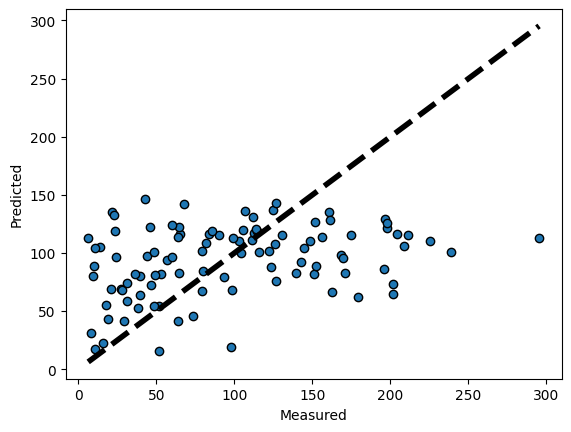

In [44]:
# Set model to evaluation mode
best_simple_model.eval()

all_predictions = []
all_targets = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_simple_model.to(device)
with torch.no_grad():
    for features, target in val_dataloader:
        features, target = features.to(device), target.to(device) # move data to GPU
        outputs = best_simple_model(features)
        all_targets.append(target)
        all_predictions.append(outputs)

# Concatenate all predictions into a single tensor
y_pred = torch.cat(all_predictions)
y_val = torch.cat(all_targets)

y_pred = y_pred.cpu()
y_val = y_val.cpu()

utils.plot_predictions(y_val, y_pred)

## Experiment 2: LSTM Layers

In [45]:
# Create model class
class ModelLSTM(nn.Module): #inherits nn.Module class
  def __init__(self,
               input_dim, # input features
               hidden_dim, # features in hidden layers
               output_dim, # output dim
               n_layers=3, # number of hidden layers
               dropout=0.2 # dropout probability
               ):
    super(ModelLSTM, self).__init__() # instantiate from nn.Module?

    self.LSTM_layers = nn.LSTM(input_dim,
                               hidden_dim,
                               num_layers=n_layers,
                               dropout=dropout,
                               batch_first=True)

    self.final_hidden_layer = nn.Linear(hidden_dim, hidden_dim)
    self.out = nn.Linear(hidden_dim, output_dim) # output layer

  def forward(self, x): #pushes numbers forward through the layers
    x, _ = self.LSTM_layers(x) # x is tensor with hidden states. _ is tuple wiht hidden state and cell state
    x = F.relu(self.final_hidden_layer(x))
    x = self.out(x)

    return x.squeeze(-1)

##### OBJECTIVE #####
def objectiveLSTM(trial):
  """
  Objective to test the LSTM model.
  Args:
    trial (optuna.Trial): The trial object.
  Returns:
    loss (float): The loss value.
  """

  # Define hyperparameters to tune
  hidden_dim = trial.suggest_int('hidden_dim', 16, 256, step=16)
  dropout = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
  num_layers = trial.suggest_int('num_layers', 2, 8)

  # Instantiate model
  LSTM_model = ModelLSTM(input_dim=len(FEATURE_COLS),
                      hidden_dim=hidden_dim,
                      output_dim=1,
                      n_layers=num_layers,
                      dropout=dropout)

  # Loss and optimiser
  criterion = CRITERION
  optimiser = torch.optim.Adam(LSTM_model.parameters(), lr=learning_rate)

  # Train model
  loss = utils.trainModel(LSTM_model,
                          train_dataloader,
                          test_dataloader,
                          criterion,
                          optimiser,
                          num_epochs=NUM_EPOCHS)

  return loss

def finalTrainLSTM(study, n_instantsiate):
  """
  This function takes the best hyperparameters from the LSTM study, creates a
  model according to those hyparameters, and trains it.
  It also calculates validation loss.
  Args:
    study: The optuna study object.
    n_instantsiate: The number of times the model is instantiated.
  return:
    print statements of results
  """

  hidden_dim = study.best_params['hidden_dim']
  dropout = study.best_params['dropout']
  learning_rate = study.best_params['learning_rate']
  num_layers = study.best_params['num_layers']

  best_model = None
  best_val_loss = float('inf')

  for i in range(n_instantsiate):
    # Instantiate model
    model = ModelLSTM(input_dim=len(FEATURE_COLS),
                    hidden_dim=hidden_dim,
                    output_dim=1,
                    n_layers=num_layers,
                    dropout=dropout)

    # Define loss function
    criterion = CRITERION

    # Define optimiser
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = trainModel(model,
                            train_dataloader,
                            test_dataloader,
                            criterion,
                            optimiser,
                            num_epochs=10)

    # validation test
    model.eval() # set to evaluation mode
    val_loss = 0.0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    with torch.no_grad(): # disable gradient calculation
      for features, target in val_dataloader:
        features, target = features.to(device), target.to(device) # move data to GPU

        outputs = model(features)
        val_loss += criterion(outputs, target).item()

    avg_val_loss = val_loss / len(val_dataloader)

    if val_loss < best_val_loss:
      best_train_loss = train_loss
      best_val_loss = avg_val_loss
      best_model = model

  print(f'Train loss: {best_train_loss:.3f} \nValidation loss: {best_val_loss:.3f}')
  return best_model




In [46]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study2 = optuna.create_study(direction='minimize')
study2.optimize(objectiveLSTM, n_trials=150)

print(f'Best trial: {study2.best_trial.value}')
print(f'Best params: {study2.best_trial.params}')

finalTrainLSTM(study2, n_instantsiate=15)

[W 2024-08-03 15:46:46,095] Trial 0 failed with parameters: {'hidden_dim': 192, 'dropout': 0.5, 'learning_rate': 0.0005738561422751748, 'num_layers': 2} because of the following error: NameError("name 'trainModel' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-45-c68a38f624ad>", line 56, in objectiveLSTM
    loss = trainModel(LSTM_model,
NameError: name 'trainModel' is not defined
[W 2024-08-03 15:46:46,099] Trial 0 failed with value None.


NameError: name 'trainModel' is not defined

LSTM layers seem to make the model worse. There is an interesting phenomenon whereby the loss drops to very low values with just a single layer. Not really sure what is going on there.  
It doesn't surprise me that it is worse, because the data is not sequential. LSTM layers are designed for sequential data. I only tried because I thought it might encourage the model to identify more interactions between genes.

# Experiment 3: Support Vector Regression  
Kernel was initially the most important hyperparameter when tuning. `rbf` was quite clearly producing the best results.

In [ ]:
from sklearn.svm import SVR
from sklearn import metrics
from matplotlib import pyplot as plt

In [ ]:
# Pre processing
X = df_filt[FEATURE_COLS]
y = df_filt['overall_survival_months']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training
svr_lin = SVR(kernel = 'linear')
svr_rbf = SVR(kernel = 'rbf')
svr_poly = SVR(kernel = 'poly')

svr_lin.fit(X_train, y_train)
svr_rbf.fit(X_train, y_train)
svr_poly.fit(X_train, y_train)

# Predictions
y_pred_lin = svr_lin.predict(X_test)
y_pred_rbf = svr_rbf.predict(X_test)
y_pred_poly = svr_poly.predict(X_test)

# Metrics
print("Linear Kernel")
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_lin))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin)))
print("R2:", metrics.r2_score(y_test, y_pred_lin))

print('rbf Kernel')
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_rbf))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_rbf)))
print("R2:", metrics.r2_score(y_test, y_pred_rbf))

print('poly Kernel')
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_poly))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_poly)))
print("R2:", metrics.r2_score(y_test, y_pred_poly))


In [ ]:
# Hyperparameter tuning
def objectiveSVR(trial):
  """
  Objective to test the SVR model.
  Args:
    trial (optuna.Trial): The trial object.
  Returns:
    loss (float): The loss value (MAE)
    """

  # Define hyperparameters to tune
  C = trial.suggest_int('C', 1, 30)
  epsilon = trial.suggest_float('epsilon', 0.01, 1)
  # kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
  kernel = 'rbf'

  # Instantiate model
  model = SVR(kernel = kernel, C=C, epsilon=epsilon)

  # Train model
  model.fit(X_train, y_train)

  # Predictions
  y_pred = model.predict(X_test)

  # Metrics
  loss = metrics.mean_absolute_error(y_test, y_pred)

  return loss

In [ ]:
%%capture
study3 = optuna.create_study(direction='minimize')
study3.optimize(objectiveSVR, n_trials=150)

In [ ]:
print(f'Best trial: {study3.best_trial.value}')
print(f'Best params: {study3.best_trial.params}')

In [ ]:
optuna.visualization.plot_slice(study3)

In [ ]:
optuna.visualization.plot_param_importances(study3)

In [ ]:
C = study3.best_params['C']
epsilon = study3.best_params['epsilon']

# Instantiate model
SVRmodel = SVR(kernel = 'rbf', C=C, epsilon=epsilon)

# Train model
SVRmodel.fit(X_train, y_train)

# Predictions
y_pred = SVRmodel.predict(X_test)

In [ ]:
utils.plot_predictions(y_test, y_pred)